In [28]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV
import tensorflow as tf

In [29]:
# 预处理输入数据
def preprocessing(nmp_df,power_df):
    nmp_df.head(10)
    power_df.head(10)
    fix_df=pd.merge(nmp_df, power_df, on=['Datetime'], how='left')
    fix_df.head(10)
    fix_df.describe()

    return fix_df


In [30]:
# 读取数据
his_nmp_gf_df = pd.read_csv('03 His_NWP_GF.CSV',parse_dates=["Datetime"],index_col=[0])
his_power_gf_df = pd.read_csv('02 His_Power_GF.CSV',parse_dates=["Datetime"],index_col=[0])
his_gf_df=preprocessing(his_nmp_gf_df,his_power_gf_df)
his_gf_df.to_csv('his_gf.csv',encoding = 'utf-8') #存储合并后数据


In [31]:
df=pd.read_csv('his_gf.csv',parse_dates=["Datetime"],index_col=[0])
df.head()

,Irradiance,Speed10,Direction10,Temper,Pressure,Humidity,Power(MW)
Datetime,,,,,,,
2022-06-13 00:00:00,0.0,6.9614,14.8148,27.32,998.67,92.59,0.0
2022-06-13 00:15:00,0.0,7.0349,15.1623,27.33,998.68,92.40,0.0
2022-06-13 00:30:00,0.0,7.1234,14.3874,27.31,998.54,92.42,0.0
2022-06-13 00:45:00,0.0,7.2816,15.6968,27.29,998.21,92.27,0.0
2022-06-13 01:00:00,0.0,7.2544,18.7347,27.34,997.92,91.92,0.0


In [32]:
df.drop('Pressure', axis=1, inplace=True)

In [33]:

df.tail()

,Irradiance,Speed10,Direction10,Temper,Humidity,Power(MW)
Datetime,,,,,,
2022-06-19 22:45:00,0.0,8.8735,7.3813,27.97,91.88,0.0
2022-06-19 23:00:00,0.0,7.6355,357.8234,27.16,0.00,0.0
2022-06-19 23:15:00,0.0,7.0539,352.9153,27.19,0.00,0.0
2022-06-19 23:30:00,0.0,6.7206,350.5797,27.27,0.00,0.0
2022-06-19 23:45:00,0.0,7.0146,352.2164,27.27,0.00,0.0


In [34]:
df.shape

(672, 6)

In [35]:
df_feaformm=pd.read_csv('04 Fore_NWP_GF.CSV',parse_dates=["Datetime"],index_col=[0])
df_feaformm.drop('Pressure', axis=1, inplace=True)
df_feaformm.tail(10)

,Irradiance,Speed10,Direction10,Temper,Humidity
Datetime,,,,,
2022-07-21 21:30:00,0.0,3.8147,40.7479,27.76,80.12
2022-07-21 21:45:00,0.0,3.8006,40.7321,27.73,80.43
2022-07-21 22:00:00,0.0,3.8118,41.3839,27.69,80.75
2022-07-21 22:15:00,0.0,3.9306,41.8030,27.67,80.87
2022-07-21 22:30:00,0.0,4.0743,41.3182,27.65,80.98
2022-07-21 22:45:00,0.0,4.3397,40.7015,27.68,80.90
2022-07-21 23:00:00,0.0,4.4797,41.0175,27.65,0.00
2022-07-21 23:15:00,0.0,3.7592,38.3028,27.33,0.00
2022-07-21 23:30:00,0.0,3.8079,39.4588,27.38,0.00


In [36]:
# 划分train valid test集
gf_df_train = df[:int(0.6*len(df))]
gf_df_valid = df[int(0.6*len(df)):int(0.8*len(df))]
gf_df_test =df[int(0.8*len(df))-7:]

In [37]:
gf_df_test.head(10)

,Irradiance,Speed10,Direction10,Temper,Humidity,Power(MW)
Datetime,,,,,,
2022-06-18 12:30:00,717.06,8.6133,26.6245,29.35,82.42,61.2424
2022-06-18 12:45:00,588.22,8.5734,26.0869,29.19,83.03,59.6648
2022-06-18 13:00:00,531.92,8.5708,25.2794,29.10,83.67,62.3017
2022-06-18 13:15:00,475.16,8.5900,24.9242,29.00,84.12,59.3981
2022-06-18 13:30:00,539.46,8.6055,24.5101,29.07,84.16,60.3202
2022-06-18 13:45:00,631.80,8.5547,23.4185,29.20,83.64,61.5091
2022-06-18 14:00:00,620.64,8.5071,21.2261,29.22,83.36,55.7019
2022-06-18 14:15:00,660.03,8.4976,19.0959,29.24,83.62,56.6240
2022-06-18 14:30:00,704.20,8.5351,18.1590,29.27,83.67,56.0982


In [38]:
gf_df_test_copy=gf_df_test.copy()
full_df_fea=gf_df_test_copy.append(df_feaformm)
full_df_fea.to_csv('full_df_fea.csv',encoding = 'utf-8')
full_df_fea

C:\Users\曹瑜\AppData\Local\Temp\ipykernel_29920\3707190378.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df_fea=gf_df_test_copy.append(df_feaformm)


,Irradiance,Speed10,Direction10,Temper,Humidity,Power(MW)
Datetime,,,,,,
2022-06-18 12:30:00,717.06,8.6133,26.6245,29.35,82.42,61.2424
2022-06-18 12:45:00,588.22,8.5734,26.0869,29.19,83.03,59.6648
2022-06-18 13:00:00,531.92,8.5708,25.2794,29.10,83.67,62.3017
2022-06-18 13:15:00,475.16,8.5900,24.9242,29.00,84.12,59.3981
2022-06-18 13:30:00,539.46,8.6055,24.5101,29.07,84.16,60.3202
...,...,...,...,...,...,...
2022-07-21 22:45:00,0.00,4.3397,40.7015,27.68,80.90,NaN
2022-07-21 23:00:00,0.00,4.4797,41.0175,27.65,0.00,NaN
2022-07-21 23:15:00,0.00,3.7592,38.3028,27.33,0.00,NaN


In [39]:
gf_df_train

,Irradiance,Speed10,Direction10,Temper,Humidity,Power(MW)
Datetime,,,,,,
2022-06-13 00:00:00,0.0,6.9614,14.8148,27.32,92.59,0.0
2022-06-13 00:15:00,0.0,7.0349,15.1623,27.33,92.40,0.0
2022-06-13 00:30:00,0.0,7.1234,14.3874,27.31,92.42,0.0
2022-06-13 00:45:00,0.0,7.2816,15.6968,27.29,92.27,0.0
2022-06-13 01:00:00,0.0,7.2544,18.7347,27.34,91.92,0.0
...,...,...,...,...,...,...
2022-06-17 03:30:00,0.0,6.4324,19.0546,27.67,90.43,0.0
2022-06-17 03:45:00,0.0,6.4961,19.3275,27.65,90.19,0.0
2022-06-17 04:00:00,0.0,6.4812,19.7490,27.62,90.29,0.0


In [40]:
df_copy=df.copy()

In [41]:
mm_df=df_copy.append(df_feaformm)

mm_df

C:\Users\曹瑜\AppData\Local\Temp\ipykernel_29920\3205568615.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mm_df=df_copy.append(df_feaformm)


,Irradiance,Speed10,Direction10,Temper,Humidity,Power(MW)
Datetime,,,,,,
2022-06-13 00:00:00,0.0,6.9614,14.8148,27.32,92.59,0.0
2022-06-13 00:15:00,0.0,7.0349,15.1623,27.33,92.40,0.0
2022-06-13 00:30:00,0.0,7.1234,14.3874,27.31,92.42,0.0
2022-06-13 00:45:00,0.0,7.2816,15.6968,27.29,92.27,0.0
2022-06-13 01:00:00,0.0,7.2544,18.7347,27.34,91.92,0.0
...,...,...,...,...,...,...
2022-07-21 22:45:00,0.0,4.3397,40.7015,27.68,80.90,NaN
2022-07-21 23:00:00,0.0,4.4797,41.0175,27.65,0.00,NaN
2022-07-21 23:15:00,0.0,3.7592,38.3028,27.33,0.00,NaN


In [42]:


# def standardization1():
#     """
#     标准化缩放
#     :return:
#     """
#     std = StandardScaler()

#     # 处理之后每列来说所有数据都聚集在均值0附近方差为1
#     #  X:numpy array格式的数据[n_samples,n_features]
#     #  返回值：转换后的形状相同的array
#     data = std.fit_transform(gf_df_train)

#     print(data)

#     return None
# # if __name__ == '__main__':
# #     standardization1()
# def standardization2():
#     """
#     标准化缩放
#     :return:
#     """
#     std = StandardScaler()

#     # 处理之后每列来说所有数据都聚集在均值0附近方差为1
#     #  X:numpy array格式的数据[n_samples,n_features]
#     #  返回值：转换后的形状相同的array
#     data = std.fit_transform(gf_df_valid)

#     print(data)

#     return None
# # if __name__ == '__main__':
# #     standardization2()
# def standardization3():
#     """
#     标准化缩放
#     :return:
#     """
#     std = StandardScaler()

#     # 处理之后每列来说所有数据都聚集在均值0附近方差为1
#     #  X:numpy array格式的数据[n_samples,n_features]
#     #  返回值：转换后的形状相同的array
#     data = std.fit_transform(gf_df_test)

#     print(data)

#     return None
# # if __name__ == '__main__':
# #     standardization3()
# # # 对数据进行归一化处理
# # # scaler = MinMaxScaler(feature_range=(0,1))
# # #scaler = standardization()
# df_for_training_scaled =standardization1()
# #df_for_training_scaled= pd.DataFrame(df_for_training_scaled)

# df_for_validing_scaled=standardization2()

# df_for_testing_scaled=standardization3() 

# #df_for_training_scaled=np.array(df_for_training_scaled,dtype="array")
# df_for_training_scaled=np.array(df_for_training_scaled,dtype=float)
# df_for_validing_scaled=np.array(df_for_validing_scaled,dtype=float)
# df_for_testing_scaled=np.array(df_for_testing_scaled,dtype=float)
# print(type(df_for_training_scaled))


# 对数据进行归一化处理
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(mm_df)
df_for_training_scaled=scaler.transform(gf_df_train)
df_for_validing_scaled=scaler.transform(gf_df_valid)
df_for_testing_scaled=scaler.transform(gf_df_test)
df_for_training_scaled
print(type(df_for_validing_scaled))

train_mean1=gf_df_train['Irradiance'].mean()
train_mean2=gf_df_train['Speed10'].mean()
train_mean3=gf_df_train['Direction10'].mean()
train_mean4=gf_df_train['Temper'].mean()
train_mean5=gf_df_train['Humidity'].mean()
gf_df_train['Irradiance']=gf_df_train['Irradiance']/train_mean1
gf_df_train['Speed10']=gf_df_train['Speed10']/train_mean2
gf_df_train['Direction10']=gf_df_train['Direction10']/train_mean3
gf_df_train['Temper']=gf_df_train['Temper']/train_mean4
gf_df_train['Humidity']=gf_df_train['Humidity']/train_mean5
# def zhongweishu(gf_df_train):
#     gf_df_train=gf_df_train.replace(gf_df_train['Temper'],0 )
#     return gf_df_train
valid_mean1=gf_df_valid['Irradiance'].mean()
valid_mean2=gf_df_valid['Speed10'].mean()
valid_mean3=gf_df_valid['Direction10'].mean()
valid_mean4=gf_df_valid['Temper'].mean()
valid_mean5=gf_df_valid['Humidity'].mean()
gf_df_valid['Irradiance']=gf_df_valid['Irradiance']/valid_mean1
gf_df_valid['Speed10']=gf_df_valid['Speed10']/valid_mean2
gf_df_valid['Direction10']=gf_df_valid['Direction10']/valid_mean3
gf_df_valid['Temper']=gf_df_valid['Temper']/valid_mean4
gf_df_valid['Humidity']=gf_df_valid['Humidity']/valid_mean5

test_mean1=gf_df_test['Irradiance'].mean()
test_mean2=gf_df_test['Speed10'].mean()
test_mean3=gf_df_test['Direction10'].mean()
test_mean4=gf_df_test['Temper'].mean()
test_mean5=gf_df_test['Humidity'].mean()
gf_df_test['Irradiance']=gf_df_test['Irradiance']/test_mean1
gf_df_test['Speed10']=gf_df_test['Speed10']/test_mean2
gf_df_test['Direction10']=gf_df_test['Direction10']/test_mean3
gf_df_test['Temper']=gf_df_test['Temper']/test_mean4
gf_df_test['Humidity']=gf_df_test['Humidity']/test_mean5

df_for_training_scaled=gf_df_train
df_for_validing_scaled=gf_df_valid
df_for_testing_scaled=gf_df_test

df_for_training_scaled=df_for_training_scaled.values
df_for_validing_scaled=df_for_validing_scaled.values
df_for_testing_scaled=df_for_testing_scaled.values

# print(gf_df_train)
# print(gf_df_valid)

print(df_for_testing_scaled)
print(type(df_for_validing_scaled))







<class 'numpy.ndarray'>
[[2.98235498e+00 1.01424341e+00 7.67788916e-01 1.03767313e+00
  9.79703016e-01 6.12424000e+01]
 [2.44649102e+00 1.00954506e+00 7.52285777e-01 1.03201631e+00
  9.86953912e-01 5.96648000e+01]
 [2.21233127e+00 1.00923890e+00 7.28999348e-01 1.02883435e+00
  9.94561410e-01 6.23017000e+01]
 [1.97625832e+00 1.01149976e+00 7.18756202e-01 1.02529884e+00
  9.99910431e-01 5.93981000e+01]
 [2.24369121e+00 1.01332493e+00 7.06814517e-01 1.02777370e+00
  1.00038590e+00 6.03202000e+01]
 [2.62774646e+00 1.00734307e+00 6.75335302e-01 1.03236986e+00
  9.94204808e-01 6.15091000e+01]
 [2.58133043e+00 1.00173802e+00 6.12111563e-01 1.03307697e+00
  9.90876528e-01 5.57019000e+01]
 [2.74515907e+00 1.00061937e+00 5.50681529e-01 1.03378407e+00
  9.93967074e-01 5.66240000e+01]
 [2.92886841e+00 1.00503511e+00 5.23663503e-01 1.03484472e+00
  9.94561410e-01 5.60982000e+01]
 [2.68634879e+00 1.01182947e+00 5.07906592e-01 1.03236986e+00
  9.96819885e-01 5.18761000e+01]
 [2.49677505e+00 1.0192596

C:\Users\曹瑜\AppData\Local\Temp\ipykernel_29920\1774935404.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gf_df_train['Irradiance']=gf_df_train['Irradiance']/train_mean1
C:\Users\曹瑜\AppData\Local\Temp\ipykernel_29920\1774935404.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gf_df_train['Speed10']=gf_df_train['Speed10']/train_mean2
C:\Users\曹瑜\AppData\Local\Temp\ipykernel_29920\1774935404.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [43]:
# 分离x与y
def createXY(array, days_used_to_train=7):
    features = list()
    labels = list()

    for i in range(days_used_to_train, len(array)):
        features.append(array[i-days_used_to_train:i, :])
        labels.append(array[i, -1])
    return np.array(features), np.array(labels)

train_X,train_y=createXY(df_for_training_scaled)
valid_X,valid_y=createXY(df_for_validing_scaled)
test_X,test_y=createXY(df_for_testing_scaled)

In [44]:
df_X,df_y=createXY(np.array(df))

In [45]:
train_X.shape

(396, 7, 6)

In [46]:
train_y.shape

(396,)

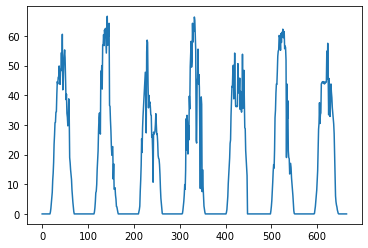

In [47]:
# 看一下历史波形
plt.plot(range(len(df_y)), df_y, label='history')

In [48]:
# 定义一个新的评价函数
def ev(y_true, y_predict):
    difference=(abs(np.array(y_true) - np.array(y_predict.flatten()))).sum()
    return float(difference) 

In [49]:
# 建立模型函数
def build_model(size):
    tf.random.set_seed(1) #设置随机数种子
    # Create grid_model
    grid_model = tf.keras.Sequential()
    grid_model.add(tf.keras.layers.LSTM(units=64))
    grid_model.add(tf.keras.layers.Dense(size))
    grid_model.add(tf.keras.layers.Dense(size))
    grid_model.add(tf.keras.layers.Dense(1))

    # Compile the grid_model
    grid_model.compile(
    optimizer='adam',
    loss='mse')
    
    return grid_model

In [50]:
# 准备一些copy用用
df_for_testing_scaled_1=df_for_testing_scaled.copy()
df_for_testing_scaled_inloop=df_for_testing_scaled.copy()
# df_for_validing_scaled_inloop=df_for_validing_scaled.copy()
df_for_testing_scaled_1=pd.DataFrame(df_for_testing_scaled_1)
df_for_testing_scaled_inloop=pd.DataFrame(df_for_testing_scaled_inloop)
# df_for_validing_scaled_inloop=pd.DataFrame(df_for_validing_scaled_inloop)
df_for_testing_scaled_1_array=df_for_testing_scaled_1.values
df_for_testing_scaled_inloop_array=df_for_testing_scaled_inloop.values
df_for_testing_scaled_inloop.iloc[7:,-1]=np.nan
df_for_testing_scaled_inloop

,0,1,2,3,4,5
0,2.982355,1.014243,0.767789,1.037673,0.979703,61.2424
1,2.446491,1.009545,0.752286,1.032016,0.986954,59.6648
2,2.212331,1.009239,0.728999,1.028834,0.994561,62.3017
3,1.976258,1.011500,0.718756,1.025299,0.999910,59.3981
4,2.243691,1.013325,0.706815,1.027774,1.000386,60.3202
...,...,...,...,...,...,...
137,0.000000,1.044883,0.212860,0.988883,1.092151,NaN
138,0.000000,0.899104,10.318798,0.960245,0.000000,NaN
139,0.000000,0.830619,10.177260,0.961306,0.000000,NaN
140,0.000000,0.791372,10.109907,0.964134,0.000000,NaN


In [51]:
df_for_testing_scaled_inloop.to_csv('df_for_testing_scaled_inloop2.csv',encoding = 'utf-8') #存储合并后数据

In [52]:
# 为循环初始化一些数据
bestscore=1000
flag=0
num=0
best_size=0
best_batch_size=0
best_epochs=0
time_step=7

In [53]:
# 开始循环（warning不影响做）
for size in [8]:
    for batch_size in [32]:
        for epochs in [30]:
            grid_model=build_model(size)
            grid_model.fit(
            train_X, train_y,
            validation_data=(valid_X, valid_y),
            batch_size=32,
            epochs=epochs,
            verbose=0)
            all_data_test=[]
# 此处用了和feature一样的逐点预测方法
            for i in range (time_step,len(df_for_testing_scaled_inloop_array)) :
                 data_x=[]
                 data_x.append( df_for_testing_scaled_inloop_array[i-time_step :i , 0:df_for_testing_scaled_inloop.shape[1]])
                 data_x=np.array(data_x)
                 prediction=grid_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_test.append(prediction)
                 df_for_testing_scaled_inloop.iloc[i,-1]=prediction
            score=ev(test_y,np.array(all_data_test))
            print('num:',num,'score=',score,'size=',size,'batch_size=',batch_size,'epochs=',epochs,)
            num=num+1
            if score<bestscore:
                flag=1
                bestscore=score
                print(bestscore)
                best_size=size
                best_batch_size=batch_size
                best_epochs=epochs
                # Export the model to a SavedModel
                grid_model.save('keras_model_tf_version', save_format='tf')
print(bestscore,'best_size=',best_size,'best_batch_size=',best_batch_size,'best_epochs=',best_epochs)

num: 0 score= 4783.0590257080075 size= 8 batch_size= 32 epochs= 30
1000 best_size= 0 best_batch_size= 0 best_epochs= 0


In [54]:
df_for_testing_scaled_inloop.head(20)

,0,1,2,3,4,5
0,2.982355,1.014243,0.767789,1.037673,0.979703,61.242400
1,2.446491,1.009545,0.752286,1.032016,0.986954,59.664800
2,2.212331,1.009239,0.728999,1.028834,0.994561,62.301700
3,1.976258,1.011500,0.718756,1.025299,0.999910,59.398100
4,2.243691,1.013325,0.706815,1.027774,1.000386,60.320200
5,2.627746,1.007343,0.675335,1.032370,0.994205,61.509100
6,2.581330,1.001738,0.612112,1.033077,0.990877,55.701900
7,2.745159,1.000619,0.550682,1.033784,0.993967,56.283062
8,2.928868,1.005035,0.523664,1.034845,0.994561,56.329311
9,2.686349,1.011829,0.507907,1.032370,0.996820,56.302708


In [55]:
# 加载最佳模型
my_model = tf.keras.models.load_model('keras_model_tf_version')

In [56]:
# 用最佳模型预测一下test
all_data_test=[]
for i in range (time_step,len(df_for_testing_scaled_1_array)) :
                 data_x=[]
                 data_x.append( df_for_testing_scaled_1_array[i-time_step :i , 0:df_for_testing_scaled_1.shape[1]])
                 data_x=np.array(data_x)
                 prediction=my_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_test.append(prediction)
                 df_for_testing_scaled_1.iloc[i,-1]=prediction

In [57]:
ev(test_y,np.array(all_data_test))

C:\Users\曹瑜\AppData\Local\Temp\ipykernel_29920\4268011167.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ev(test_y,np.array(all_data_test))


1914.5594482421875

d:\anaconda2\envs\note2\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


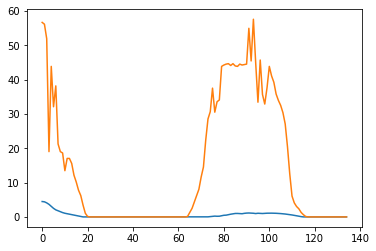

In [58]:
# 看看test的结果
plt.plot(range(len(all_data_test)), all_data_test, label='Prediction')
plt.plot(range(len(test_y)), test_y, label='Prediction')

In [59]:
# Recreate the exact same model
new_pred_valid_y=my_model.predict(valid_X)
ev(valid_y,new_pred_valid_y)

4/4 [==============================] - 0s 4ms/step


2441.589894925809

4/4 [==============================] - 0s 4ms/step


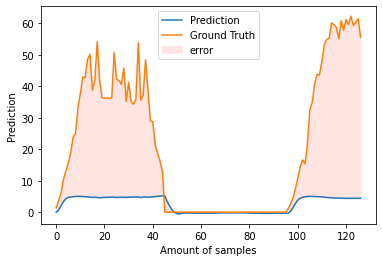

In [60]:
# 查看valid集预测结果
pred_valid_y = my_model.predict(valid_X)
plt.plot(range(len(pred_valid_y)), pred_valid_y, label='Prediction')
plt.plot(range(len(pred_valid_y)), valid_y, label='Ground Truth')
plt.fill_between(range(len(pred_valid_y)), pred_valid_y.flatten(), valid_y.flatten(), color='MistyRose',label='error')
plt.xlabel('Amount of samples')
plt.ylabel('Prediction')
plt.legend()
plt.show()

In [61]:
ev(valid_y,pred_valid_y)

2441.589894925809

In [62]:
df_fea=pd.read_csv('full_df_fea.csv',index_col=[0])
df_fea

,Irradiance,Speed10,Direction10,Temper,Humidity,Power(MW)
Datetime,,,,,,
2022-06-18 12:30:00,717.06,8.6133,26.6245,29.35,82.42,61.2424
2022-06-18 12:45:00,588.22,8.5734,26.0869,29.19,83.03,59.6648
2022-06-18 13:00:00,531.92,8.5708,25.2794,29.10,83.67,62.3017
2022-06-18 13:15:00,475.16,8.5900,24.9242,29.00,84.12,59.3981
2022-06-18 13:30:00,539.46,8.6055,24.5101,29.07,84.16,60.3202
...,...,...,...,...,...,...
2022-07-21 22:45:00,0.00,4.3397,40.7015,27.68,80.90,NaN
2022-07-21 23:00:00,0.00,4.4797,41.0175,27.65,0.00,NaN
2022-07-21 23:15:00,0.00,3.7592,38.3028,27.33,0.00,NaN


In [63]:
df_fea_array=df_fea.values

In [64]:
# 用最佳模型预测一下fea
all_data_fea=[]
for i in range (time_step,len(df_fea_array)) :
                 data_x=[]
                 data_x.append( df_fea_array[i-time_step :i , 0:df_fea.shape[1]])
                 data_x=np.array(data_x)
                 prediction=my_model.predict(data_x,verbose=0)
                 if prediction<0:
                    prediction=0
                 all_data_fea.append(prediction)
                 df_fea.iloc[i,-1]=prediction

d:\anaconda2\envs\note2\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


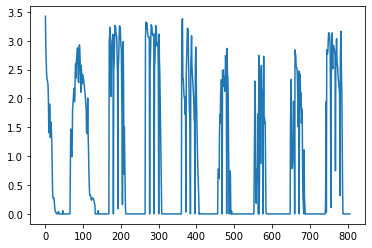

In [65]:
plt.plot(range(len(all_data_fea)), all_data_fea, label='Prediction')